## Importación de las librerías

In [35]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

## Importación de los conjuntos de entrenamiento y test

In [2]:
train = pd.read_csv('/kaggle/input/outlier-missing-treatment/train_final.csv')
train.shape

(4087, 15)

In [3]:
test = pd.read_csv('/kaggle/input/outlier-missing-treatment/test_final.csv')
test.shape

(1022, 15)

In [4]:
X_train , y_train = train.drop(columns=['stroke']), train.stroke
X_test , y_test = test.drop(columns=['stroke']), test.stroke

## Selección de variables con mutual_info_classif

Selección de variables fuentes:

**Feature Selection:**
- https://machinelearningmastery.com/feature-selection-machine-learning-python/
- https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

**LASSO:**
- https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a
- https://www.blog.trainindata.com/lasso-feature-selection-with-python/
- **https://towardsdatascience.com/beyond-linear-regression-467a7fc3bafb**

**RFE:**
- https://towardsdatascience.com/feature-engineering-recursive-feature-elimination-with-cross-validation-745d594df730

**Mutual Information: (el que se usa en este notebook)**
- https://www.blog.trainindata.com/mutual-information-with-python/


Se hace la transformación inversa de las variables **work_type** y **smoking_status**, para poder usar el **LabelEncoder** y posteriormente el **Mutual Information**

In [6]:
X_train_copy = X_train.copy()
X_train_copy.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,0.658203,1,0,1,0,0.578398,0.517302,0,0,0,1,0,0
1,1,0.707031,1,0,1,0,0.042295,0.434111,0,0,0,0,0,1
2,0,0.377441,0,0,1,1,0.927658,0.627152,0,1,0,0,0,1
3,0,0.804688,0,0,1,1,0.780787,0.458434,0,1,0,0,1,0
4,1,0.243164,0,0,0,0,0.579848,0.450477,1,0,0,0,0,0


In [29]:
def work_type_dummies_to_text(x):
    if x[0] == 1: return 'private'
    if x[1] == 1: return 'self-employed'
    if x[2] == 1: return 'children'
    return 'govt-job'

def smoking_status_dummies_to_text(x):
    if x[0] == 1: return 'formerly-smoked'
    if x[1] == 1: return 'never-smoked'
    if x[2] == 1: return 'smokes'
    return 'unknown'    

In [27]:
X_train_copy['work_type'] = X_train_copy[['work_type_Private', 'work_type_Self-employed','work_type_children']].apply(work_type_dummies_to_text,axis=1)
X_train_copy.drop(columns=['work_type_Private', 'work_type_Self-employed','work_type_children'], inplace=True)

In [30]:
X_train_copy['smoking_status'] = X_train_copy[['smoking_status_formerly smoked', 'smoking_status_never smoked','smoking_status_smokes']].apply(smoking_status_dummies_to_text,axis=1)
X_train_copy.drop(columns=['smoking_status_formerly smoked', 'smoking_status_never smoked','smoking_status_smokes'], inplace=True)

In [33]:
X_train_copy.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type,smoking_status
0,1,0.658203,1,0,1,0,0.578398,0.517302,govt-job,formerly-smoked
1,1,0.707031,1,0,1,0,0.042295,0.434111,govt-job,smokes
2,0,0.377441,0,0,1,1,0.927658,0.627152,self-employed,smokes
3,0,0.804688,0,0,1,1,0.780787,0.458434,self-employed,never-smoked
4,1,0.243164,0,0,0,0,0.579848,0.450477,private,unknown


Utilizamos el LabelEncoder:

In [45]:
label_encoder = LabelEncoder()
X_train_copy['work_type'] = label_encoder.fit_transform(X_train_copy.work_type)
X_train_copy['smoking_status'] = label_encoder.fit_transform(X_train_copy.smoking_status)
X_train_copy.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type,smoking_status
0,1,0.658203,1,0,1,0,0.578398,0.517302,1,0
1,1,0.707031,1,0,1,0,0.042295,0.434111,1,2
2,0,0.377441,0,0,1,1,0.927658,0.627152,3,2
3,0,0.804688,0,0,1,1,0.780787,0.458434,3,1
4,1,0.243164,0,0,0,0,0.579848,0.450477,2,3


Calculamos el mutual information para cada variable con respecto a la target binaria.

Teniendo en cuenta el MI se escogen las siguentes variables para el entrenamiento de los distintos modelos: **age**, **bmi**, **ever_married**, **hypertension**, **work_type**, **heart_disease**, **avg_glucose_level** y **smoking_status**

In [47]:
discrete_vars = [True, False, True, True, True, True, False, False, True, True]
mutual_info = mutual_info_classif(X_train_copy, y_train, discrete_features=discrete_vars)

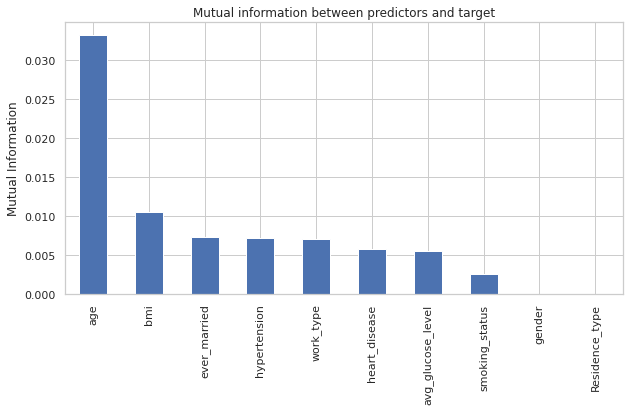

In [52]:
mutual_info_df = pd.Series(mutual_info)
mutual_info_df.index = X_train_copy.columns
mutual_info_df.sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.ylabel('Mutual Information')
plt.title("Mutual information between predictors and target")
plt.show()

## Guardado de las variables finales para el modelado

In [54]:
X_train.drop(columns=['gender', 'Residence_type'], inplace=True)
X_test.drop(columns=['gender', 'Residence_type'], inplace=True)

In [57]:
X_train['stroke'] = y_train
X_test['stroke'] = y_test

In [61]:
X_train.to_csv('train.csv', index=False)
X_test.to_csv('test.csv', index=False)